In [ ]:
import pandas as pd
import numpy as np

# Load and clean the data
df = pd.read_csv(r'.Data\taylorParkReservoir.csv')

# Clean date column (remove time component)
df['Date'] = pd.to_datetime(df['Date']).dt.date

# Check missing data
print("Missing data count:")
print(df.isnull().sum())

# Handle missing storage data
print(f"\nTotal rows: {len(df)}")
print(f"Missing storage: {df['Storage (af)'].isnull().sum()}")

# Option 1: Drop rows with missing storage (if too many missing)
df_clean = df.dropna(subset=['Storage (af)'])

# Option 2: Forward fill missing storage (if occasional gaps)
# df['Storage (af)'] = df['Storage (af)'].fillna(method='ffill')

print(f"Rows after cleaning: {len(df_clean)}")
print(f"Date range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")

# Show sample of clean data
print("\nClean data sample:")
print(df_clean.head(10))

Missing data count:
Date                0
Inflow(cfs)         0
Storage (af)      943
Elevation (ft)      0
Release (cfs)       0
dtype: int64

Total rows: 13485
Missing storage: 943
Rows after cleaning: 12542
Date range: 1990-08-01 to 2024-12-01

Clean data sample:
           Date  Inflow(cfs)  Storage (af)  Elevation (ft)  Release (cfs)
943  1990-08-01        51.89       96699.8         9325.20          247.0
944  1990-08-02       149.19       96506.8         9325.10          247.0
945  1990-08-03       101.80       96217.7         9324.95          247.0
946  1990-08-04        52.90       95832.9         9324.75          247.0
947  1990-08-05        53.40       95449.0         9324.55          247.0
948  1990-08-06       102.31       95161.6         9324.40          247.0
949  1990-08-07       149.20       94970.3         9324.30          246.0
950  1990-08-08       101.81       94683.7         9324.15          246.0
951  1990-08-09       101.81       94397.6         9324.00         

In [ ]:
import pandas as pd
import numpy as np

# Fix the copy warnings
df = pd.read_csv(r'.Data\taylorParkReservoir.csv')
df['Date'] = pd.to_datetime(df['Date']).dt.date

# Create a proper clean copy
df_clean = df.dropna(subset=['Storage (af)']).copy()

# Handle negative inflows (set to 0)
df_clean.loc[df_clean['Inflow(cfs)'] < 0, 'Inflow(cfs)'] = 0

# Use official capacity
TAYLOR_PARK_CAPACITY = 106250  # acre-feet

def analyze_data_only(df_clean):
    """
    Analyze ONLY what the data shows us - no assumptions
    """

    # Calculate storage percentage
    df_clean['Storage_Percent'] = (df_clean['Storage (af)'] / TAYLOR_PARK_CAPACITY) * 100
    df_clean['Month'] = pd.to_datetime(df_clean['Date']).dt.month

    print("=== DATA-DRIVEN ANALYSIS - TAYLOR PARK RESERVOIR ===")
    print(f"Capacity: {TAYLOR_PARK_CAPACITY:,} af")
    print(f"Data Period: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
    print(f"Total Days: {len(df_clean):,}")

    # 1. Basic statistics - what does the data show?
    print(f"\nDATA SUMMARY:")
    print(f"  Storage: {df_clean['Storage (af)'].min():,.0f} to {df_clean['Storage (af)'].max():,.0f} af")
    print(f"  Storage: {df_clean['Storage_Percent'].min():.1f}% to {df_clean['Storage_Percent'].max():.1f}% full")
    print(f"  Inflow:  {df_clean['Inflow(cfs)'].min():.0f} to {df_clean['Inflow(cfs)'].max():.0f} cfs")
    print(f"  Release: {df_clean['Release (cfs)'].min():.0f} to {df_clean['Release (cfs)'].max():.0f} cfs")

    # 2. Storage-Release relationship (pure data analysis)
    print(f"\nSTORAGE-RELEASE PATTERNS:")

    storage_bins = [(37, 50), (50, 65), (65, 80), (80, 95), (95, 100)]

    for low, high in storage_bins:
        mask = (df_clean['Storage_Percent'] >= low) & (df_clean['Storage_Percent'] < high)
        if np.sum(mask) > 0:
            subset = df_clean[mask]
            avg_release = subset['Release (cfs)'].mean()
            med_release = subset['Release (cfs)'].median()
            days = len(subset)

            print(f"  {low:2d}-{high:2d}% full: Avg = {avg_release:5.1f} cfs, "
                  f"Median = {med_release:5.1f} cfs ({days:4d} days)")

    # 3. Inflow-Release relationship
    print(f"\nINFLOW-RELEASE PATTERNS:")

    # Use data-driven percentiles
    inflow_percentiles = np.percentile(df_clean['Inflow(cfs)'], [10, 25, 50, 75, 90])

    inflow_ranges = [
        (f"≤ {inflow_percentiles[0]:.0f}", df_clean['Inflow(cfs)'] <= inflow_percentiles[0]),
        (f"{inflow_percentiles[0]:.0f}-{inflow_percentiles[1]:.0f}",
         (df_clean['Inflow(cfs)'] > inflow_percentiles[0]) & (df_clean['Inflow(cfs)'] <= inflow_percentiles[1])),
        (f"{inflow_percentiles[1]:.0f}-{inflow_percentiles[3]:.0f}",
         (df_clean['Inflow(cfs)'] > inflow_percentiles[1]) & (df_clean['Inflow(cfs)'] <= inflow_percentiles[3])),
        (f"{inflow_percentiles[3]:.0f}-{inflow_percentiles[4]:.0f}",
         (df_clean['Inflow(cfs)'] > inflow_percentiles[3]) & (df_clean['Inflow(cfs)'] <= inflow_percentiles[4])),
        (f"> {inflow_percentiles[4]:.0f}", df_clean['Inflow(cfs)'] > inflow_percentiles[4])
    ]

    for range_name, mask in inflow_ranges:
        if np.sum(mask) > 0:
            subset = df_clean[mask]
            avg_inflow = subset['Inflow(cfs)'].mean()
            avg_release = subset['Release (cfs)'].mean()
            days = len(subset)

            print(f"  Inflow {range_name:8s} cfs: Avg release = {avg_release:5.1f} cfs ({days:4d} days)")

    # 4. Monthly patterns (what does data show by month?)
    print(f"\nMONTHLY PATTERNS (Data-Driven):")

    monthly_stats = df_clean.groupby('Month').agg({
        'Release (cfs)': ['mean', 'median', 'std', 'count'],
        'Inflow(cfs)': 'mean',
        'Storage_Percent': 'mean'
    }).round(1)

    print("  Month | Avg Release | Med Release | Avg Inflow | Avg Storage% | Days")
    print("  ------|-------------|-------------|------------|--------------|-----")

    for month in range(1, 13):
        if month in monthly_stats.index:
            avg_rel = monthly_stats.loc[month, ('Release (cfs)', 'mean')]
            med_rel = monthly_stats.loc[month, ('Release (cfs)', 'median')]
            avg_inf = monthly_stats.loc[month, ('Inflow(cfs)', 'mean')]
            avg_stor = monthly_stats.loc[month, ('Storage_Percent', 'mean')]
            days = monthly_stats.loc[month, ('Release (cfs)', 'count')]

            print(f"  {month:2d}    |    {avg_rel:6.1f}   |    {med_rel:6.1f}   |   {avg_inf:6.1f}   |     {avg_stor:6.1f}    | {days:4.0f}")

    # 5. Simple correlations
    storage_release_corr = df_clean['Storage_Percent'].corr(df_clean['Release (cfs)'])
    inflow_release_corr = df_clean['Inflow(cfs)'].corr(df_clean['Release (cfs)'])

    print(f"\nCORRELATIONS:")
    print(f"  Storage % - Release:  {storage_release_corr:.3f}")
    print(f"  Inflow - Release:     {inflow_release_corr:.3f}")

    # 6. Identify patterns from data only
    print(f"\nDATA-DRIVEN OBSERVATIONS:")

    # Find months with highest/lowest releases
    monthly_avg = df_clean.groupby('Month')['Release (cfs)'].mean()
    high_release_months = monthly_avg[monthly_avg > monthly_avg.quantile(0.75)].index.tolist()
    low_release_months = monthly_avg[monthly_avg < monthly_avg.quantile(0.25)].index.tolist()

    print(f"  Highest release months: {high_release_months}")
    print(f"  Lowest release months:  {low_release_months}")

    # Find storage-release decision pattern
    if storage_release_corr > 0.3:
        print(f"  Pattern: Higher storage → Higher releases (correlation = {storage_release_corr:.2f})")
    elif storage_release_corr < -0.3:
        print(f"  Pattern: Higher storage → Lower releases (correlation = {storage_release_corr:.2f})")
    else:
        print(f"  Pattern: Storage level weakly correlated with releases")

    return df_clean

# Run data-only analysis
df_analyzed = analyze_data_only(df_clean)

=== DATA-DRIVEN ANALYSIS - TAYLOR PARK RESERVOIR ===
Capacity: 106,250 af
Data Period: 1990-08-01 to 2024-12-01
Total Days: 12,542

DATA SUMMARY:
  Storage: 39,050 to 106,133 af
  Storage: 36.8% to 99.9% full
  Inflow:  0 to 2427 cfs
  Release: 27 to 1830 cfs

STORAGE-RELEASE PATTERNS:
  37-50% full: Avg = 150.2 cfs, Median =  99.9 cfs ( 523 days)
  50-65% full: Avg = 121.7 cfs, Median =  95.5 cfs (3644 days)
  65-80% full: Avg = 158.9 cfs, Median = 103.0 cfs (6131 days)
  80-95% full: Avg = 356.8 cfs, Median = 338.0 cfs (1874 days)
  95-100% full: Avg = 616.6 cfs, Median = 519.0 cfs ( 345 days)

INFLOW-RELEASE PATTERNS:
  Inflow ≤ 53     cfs: Avg release =  98.5 cfs (1258 days)
  Inflow 53-69    cfs: Avg release = 100.6 cfs (1878 days)
  Inflow 69-189   cfs: Avg release = 154.7 cfs (6270 days)
  Inflow 189-444  cfs: Avg release = 287.0 cfs (1881 days)
  Inflow > 444    cfs: Avg release = 443.7 cfs (1255 days)

MONTHLY PATTERNS (Data-Driven):
  Month | Avg Release | Med Release | Avg I

Creating visualizations for Taylor Park operations...


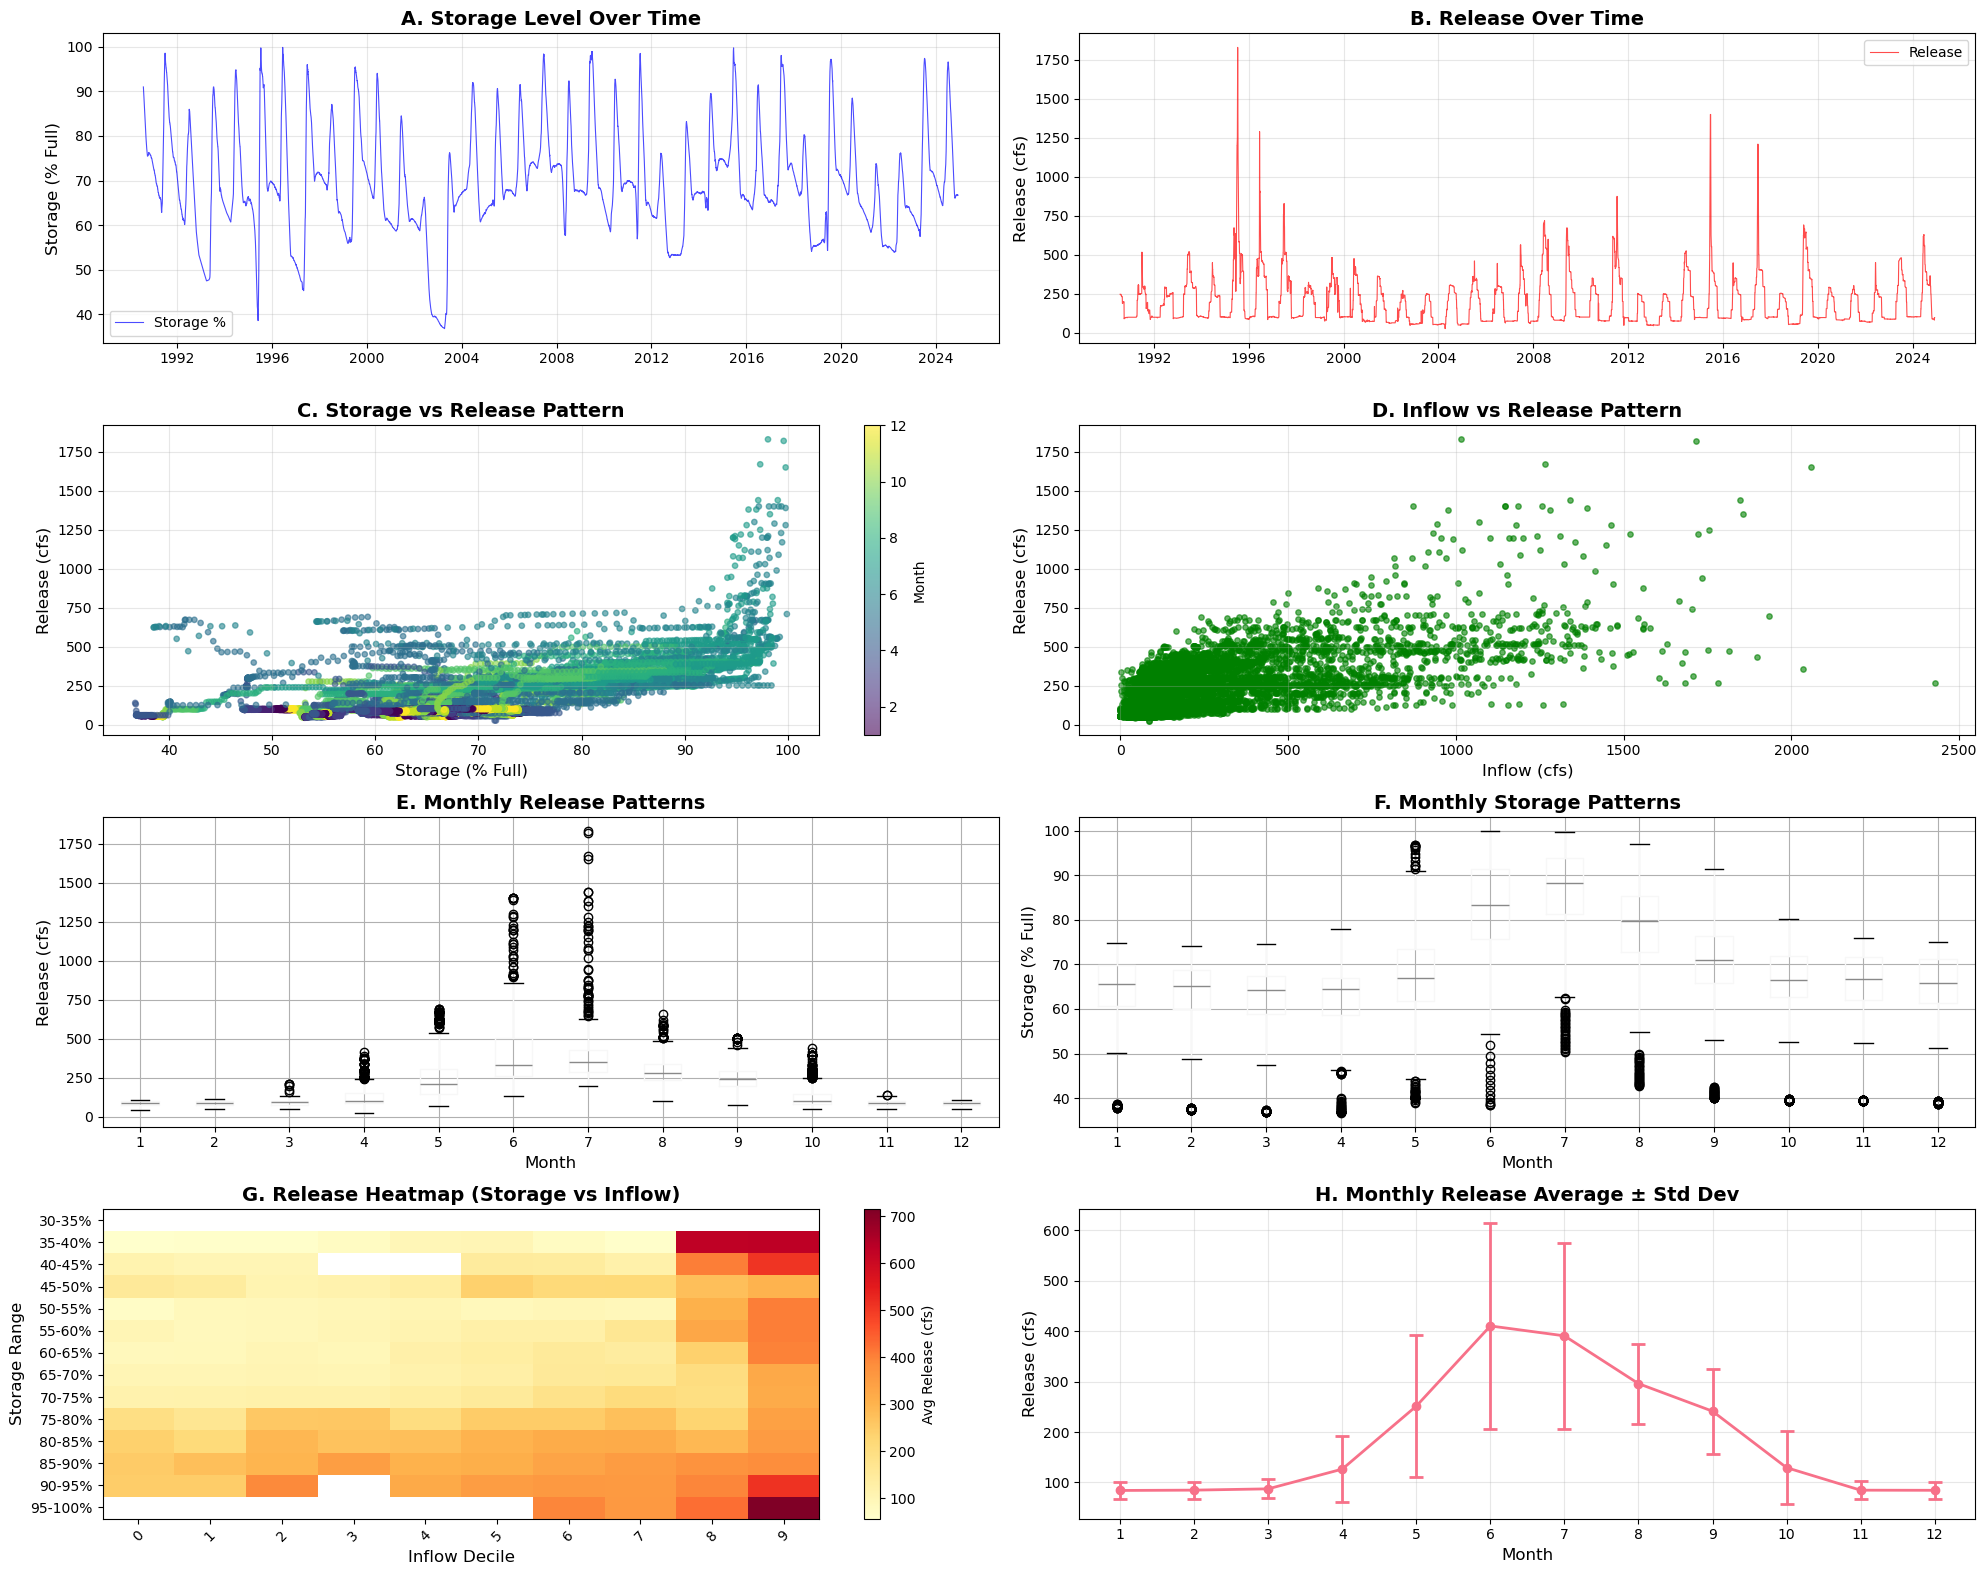

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def visualize_taylor_park_patterns(df_clean):
    """
    Create visualizations to understand reservoir operation patterns for Taylor Reserovir
    """

    fig = plt.figure(figsize=(20, 16))

    # 1. Time series overview
    ax1 = plt.subplot(4, 2, 1)
    ax1.plot(pd.to_datetime(df_clean['Date']), df_clean['Storage_Percent'],
             alpha=0.7, linewidth=0.8, color='blue', label='Storage %')
    ax1.set_ylabel('Storage (% Full)', fontsize=12)
    ax1.set_title('A. Storage Level Over Time', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # 2. Release time series
    ax2 = plt.subplot(4, 2, 2)
    ax2.plot(pd.to_datetime(df_clean['Date']), df_clean['Release (cfs)'],
             alpha=0.7, linewidth=0.8, color='red', label='Release')
    ax2.set_ylabel('Release (cfs)', fontsize=12)
    ax2.set_title('B. Release Over Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    # 3. Storage vs Release scatter plot
    ax3 = plt.subplot(4, 2, 3)
    scatter = ax3.scatter(df_clean['Storage_Percent'], df_clean['Release (cfs)'],
                         alpha=0.6, s=15, c=df_clean['Month'], cmap='viridis')
    ax3.set_xlabel('Storage (% Full)', fontsize=12)
    ax3.set_ylabel('Release (cfs)', fontsize=12)
    ax3.set_title('C. Storage vs Release Pattern', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax3)
    cbar.set_label('Month', fontsize=10)

    # 4. Inflow vs Release scatter plot
    ax4 = plt.subplot(4, 2, 4)
    ax4.scatter(df_clean['Inflow(cfs)'], df_clean['Release (cfs)'],
               alpha=0.6, s=15, color='green')
    ax4.set_xlabel('Inflow (cfs)', fontsize=12)
    ax4.set_ylabel('Release (cfs)', fontsize=12)
    ax4.set_title('D. Inflow vs Release Pattern', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # 5. Monthly patterns boxplot
    ax5 = plt.subplot(4, 2, 5)
    df_clean.boxplot(column='Release (cfs)', by='Month', ax=ax5)
    ax5.set_xlabel('Month', fontsize=12)
    ax5.set_ylabel('Release (cfs)', fontsize=12)
    ax5.set_title('E. Monthly Release Patterns', fontsize=14, fontweight='bold')
    plt.suptitle('')  # Remove automatic title

    # 6. Storage distribution by month
    ax6 = plt.subplot(4, 2, 6)
    df_clean.boxplot(column='Storage_Percent', by='Month', ax=ax6)
    ax6.set_xlabel('Month', fontsize=12)
    ax6.set_ylabel('Storage (% Full)', fontsize=12)
    ax6.set_title('F. Monthly Storage Patterns', fontsize=14, fontweight='bold')
    plt.suptitle('')  # Remove automatic title

    # 7. Heatmap of operations
    ax7 = plt.subplot(4, 2, 7)
    storage_bins = np.arange(30, 105, 5)  # 30% to 100% in 5% bins
    inflow_bins = np.percentile(df_clean['Inflow(cfs)'], np.arange(0, 101, 10))  # Decile bins

    # Create heatmap data
    heatmap_data = []
    storage_labels = []
    inflow_labels = []

    for i in range(len(storage_bins)-1):
        row = []
        if i == 0:  # Create inflow labels only once
            for j in range(len(inflow_bins)-1):
                inflow_labels.append(f"{inflow_bins[j]:.0f}-{inflow_bins[j+1]:.0f}")
        storage_labels.append(f"{storage_bins[i]:.0f}-{storage_bins[i+1]:.0f}%")

        for j in range(len(inflow_bins)-1):
            mask = ((df_clean['Storage_Percent'] >= storage_bins[i]) &
                   (df_clean['Storage_Percent'] < storage_bins[i+1]) &
                   (df_clean['Inflow(cfs)'] >= inflow_bins[j]) &
                   (df_clean['Inflow(cfs)'] < inflow_bins[j+1]))

            if np.sum(mask) > 0:
                avg_release = df_clean[mask]['Release (cfs)'].mean()
                row.append(avg_release)
            else:
                row.append(np.nan)

        heatmap_data.append(row)

    # Plot heatmap
    im = ax7.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
    ax7.set_xticks(range(len(inflow_labels)))
    ax7.set_xticklabels([f"{i}" for i in range(len(inflow_labels))], rotation=45)
    ax7.set_yticks(range(len(storage_labels)))
    ax7.set_yticklabels(storage_labels)
    ax7.set_xlabel('Inflow Decile', fontsize=12)
    ax7.set_ylabel('Storage Range', fontsize=12)
    ax7.set_title('G. Release Heatmap (Storage vs Inflow)', fontsize=14, fontweight='bold')
    cbar2 = plt.colorbar(im, ax=ax7)
    cbar2.set_label('Avg Release (cfs)', fontsize=10)

    # 8. Seasonal pattern comparison
    ax8 = plt.subplot(4, 2, 8)
    monthly_avg = df_clean.groupby('Month')['Release (cfs)'].mean()
    monthly_std = df_clean.groupby('Month')['Release (cfs)'].std()
    months = range(1, 13)
    ax8.errorbar(months, monthly_avg, yerr=monthly_std,
                marker='o', capsize=5, capthick=2, linewidth=2)
    ax8.set_xlabel('Month', fontsize=12)
    ax8.set_ylabel('Release (cfs)', fontsize=12)
    ax8.set_title('H. Monthly Release Average ± Std Dev', fontsize=14, fontweight='bold')
    ax8.grid(True, alpha=0.3)
    ax8.set_xticks(months)
    plt.tight_layout()
    plt.show()

    return fig

# Create the visualizations
print("Creating visualizations for Taylor Park operations...")
fig = visualize_taylor_park_patterns(df_analyzed)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def validate_drought_thresholds_with_ssi(ssi_file_path, reservoir_df):
    """
    Validate drought thresholds using historical SSI data

    PURPOSE:
    - Check if SSI thresholds correctly identify known drought periods
    - Validate that SSI-based rules align with actual reservoir stress periods
    - Identify periods when reservoir operations were stressed

    METHODOLOGY:
    - Compare SSI drought periods with reservoir storage depletion
    - Analyze correlation between SSI values and reservoir operations
    - Validate drought threshold definitions against actual impacts
    """

    print("=== SSI DROUGHT THRESHOLD VALIDATION ===")
    print("PURPOSE: Validate SSI drought definitions against historical reservoir stress")
    print()

    # Load SSI data
    print("1. LOADING SSI DATA:")
    ssi_df = pd.read_csv(ssi_file_path)
    print(f"   SSI data columns: {ssi_df.columns.tolist()}")
    print(f"   SSI data shape: {ssi_df.shape}")

    # Check date column and standardize
    if 'date' in ssi_df.columns:
        ssi_df['Date'] = pd.to_datetime(ssi_df['date'])
    elif 'Date' in ssi_df.columns:
        ssi_df['Date'] = pd.to_datetime(ssi_df['Date'])
    else:
        print(f"   Available columns: {ssi_df.columns.tolist()}")
        print("   ERROR: No recognizable date column found")
        return None

    # Check SSI column
    ssi_column = None
    for col in ['ssi_3', 'SSI_3', 'ssi3', 'SSI3', 'ssi']:
        if col in ssi_df.columns:
            ssi_column = col
            break

    if ssi_column is None:
        print(f"   Available columns: {ssi_df.columns.tolist()}")
        print("   ERROR: No recognizable SSI column found")
        return None

    print(f"   Using SSI column: '{ssi_column}'")
    print(f"   Date range: {ssi_df['Date'].min()} to {ssi_df['Date'].max()}")
    print(f"   SSI range: {ssi_df[ssi_column].min():.2f} to {ssi_df[ssi_column].max():.2f}")
    print()

    # 2. DEFINE DROUGHT THRESHOLDS TO TEST
    print("2. DROUGHT THRESHOLD DEFINITIONS TO VALIDATE:")
    drought_thresholds = {
        'Mild Drought': -0.5,
        'Moderate Drought': -1.0,
        'Severe Drought': -1.5,
        'Extreme Drought': -2.0
    }

    for level, threshold in drought_thresholds.items():
        count = (ssi_df[ssi_column] <= threshold).sum()
        percentage = (count / len(ssi_df)) * 100
        print(f"   {level:15s}: SSI ≤ {threshold:4.1f} ({count:4d} days, {percentage:4.1f}%)")
    print()

    # 3. MERGE WITH RESERVOIR DATA
    print("3. MERGING SSI WITH RESERVOIR DATA:")

    # Ensure both dataframes have Date column
    reservoir_df['Date'] = pd.to_datetime(reservoir_df['Date'])

    # Merge datasets
    merged_df = pd.merge(reservoir_df, ssi_df[['Date', ssi_column]],
                        on='Date', how='inner')

    print(f"   Reservoir data points: {len(reservoir_df)}")
    print(f"   SSI data points: {len(ssi_df)}")
    print(f"   Merged data points: {len(merged_df)} (overlap period)")
    print(f"   Overlap date range: {merged_df['Date'].min()} to {merged_df['Date'].max()}")
    print()

    # 4. IDENTIFY DROUGHT PERIODS IN BOTH DATASETS
    print("4. DROUGHT PERIOD IDENTIFICATION:")

    # SSI-based drought periods
    ssi_drought_periods = {}
    for level, threshold in drought_thresholds.items():
        drought_mask = merged_df[ssi_column] <= threshold
        drought_days = merged_df[drought_mask]

        if len(drought_days) > 0:
            ssi_drought_periods[level] = {
                'threshold': threshold,
                'total_days': len(drought_days),
                'percentage': (len(drought_days) / len(merged_df)) * 100,
                'min_ssi': drought_days[ssi_column].min(),
                'avg_ssi': drought_days[ssi_column].mean(),
                'avg_storage_pct': drought_days['Storage_Percent'].mean(),
                'avg_release': drought_days['Release (cfs)'].mean()
            }

    for level, stats in ssi_drought_periods.items():
        print(f"   {level:15s}: {stats['total_days']:4d} days ({stats['percentage']:4.1f}%)")
        print(f"                     SSI avg = {stats['avg_ssi']:5.2f}, "
              f"Storage avg = {stats['avg_storage_pct']:4.1f}%, "
              f"Release avg = {stats['avg_release']:5.0f} cfs")
    print()

    # 5. RESERVOIR STRESS PERIODS (Independent validation)
    print("5. RESERVOIR STRESS PERIOD IDENTIFICATION:")
    print("   Method: Identify periods of rapid storage decline or low storage")

    # Calculate storage change rates
    merged_df = merged_df.sort_values('Date').reset_index(drop=True)
    merged_df['Storage_Change_30day'] = merged_df['Storage_Percent'].diff(30)  # 30-day change

    # Define reservoir stress conditions
    stress_conditions = {
        'Low Storage': merged_df['Storage_Percent'] < 50,
        'Rapid Decline': merged_df['Storage_Change_30day'] < -10,  # >10% loss in 30 days
        'Very Low Storage': merged_df['Storage_Percent'] < 40,
        'Emergency Storage': merged_df['Storage_Percent'] < 35
    }

    stress_periods = {}
    for condition_name, condition_mask in stress_conditions.items():
        stress_days = merged_df[condition_mask]
        if len(stress_days) > 0:
            stress_periods[condition_name] = {
                'days': len(stress_days),
                'percentage': (len(stress_days) / len(merged_df)) * 100,
                'avg_ssi': stress_days[ssi_column].mean(),
                'min_ssi': stress_days[ssi_column].min(),
                'avg_storage': stress_days['Storage_Percent'].mean()
            }

    for condition, stats in stress_periods.items():
        print(f"   {condition:15s}: {stats['days']:4d} days ({stats['percentage']:4.1f}%), "
              f"Avg SSI = {stats['avg_ssi']:5.2f}")
    print()

    # 6. CORRELATION ANALYSIS
    print("6. SSI-RESERVOIR CORRELATION ANALYSIS:")

    ssi_storage_corr = merged_df[ssi_column].corr(merged_df['Storage_Percent'])
    ssi_release_corr = merged_df[ssi_column].corr(merged_df['Release (cfs)'])

    print(f"   SSI - Storage correlation:     {ssi_storage_corr:6.3f}")
    print(f"   SSI - Release correlation:     {ssi_release_corr:6.3f}")

    # Lag correlations (how well does SSI predict future storage?)
    lag_correlations = {}
    for lag_days in [30, 60, 90]:
        if len(merged_df) > lag_days:
            future_storage = merged_df['Storage_Percent'].shift(-lag_days)
            lag_corr = merged_df[ssi_column].corr(future_storage)
            lag_correlations[lag_days] = lag_corr
            print(f"   SSI - Storage (+{lag_days:2d} days):    {lag_corr:6.3f}")
    print()

    # 7. VALIDATE THRESHOLDS AGAINST STRESS PERIODS
    print("7. THRESHOLD VALIDATION:")
    print("   Question: Do SSI drought thresholds correctly identify reservoir stress?")

    validation_results = {}
    for drought_level, threshold in drought_thresholds.items():
        ssi_drought_mask = merged_df[ssi_column] <= threshold

        # Check overlap with each stress condition
        overlaps = {}
        for stress_name, stress_mask in stress_conditions.items():
            if stress_mask.sum() > 0 and ssi_drought_mask.sum() > 0:
                # Calculate overlap
                overlap_days = (ssi_drought_mask & stress_mask).sum()
                ssi_drought_days = ssi_drought_mask.sum()
                stress_days = stress_mask.sum()

                # Calculate precision and recall
                precision = overlap_days / ssi_drought_days if ssi_drought_days > 0 else 0
                recall = overlap_days / stress_days if stress_days > 0 else 0

                overlaps[stress_name] = {
                    'overlap_days': overlap_days,
                    'precision': precision,  # When SSI says drought, how often is reservoir stressed?
                    'recall': recall        # When reservoir is stressed, how often did SSI predict it?
                }

        validation_results[drought_level] = {
            'threshold': threshold,
            'overlaps': overlaps
        }

    print("   Validation Matrix (Precision = SSI accuracy, Recall = SSI coverage):")
    print("   Format: Precision% / Recall%")
    print()
    print(f"   {'Drought Level':<15} | {'Low Storage':<12} | {'Rapid Decline':<13} | {'Very Low':<12} | {'Emergency':<12}")
    print("   " + "-"*80)

    for drought_level, results in validation_results.items():
        row = f"   {drought_level:<15} |"
        for stress_condition in ['Low Storage', 'Rapid Decline', 'Very Low Storage', 'Emergency Storage']:
            if stress_condition in results['overlaps']:
                precision = results['overlaps'][stress_condition]['precision'] * 100
                recall = results['overlaps'][stress_condition]['recall'] * 100
                row += f" {precision:4.0f}% / {recall:4.0f}% |"
            else:
                row += f"      N/A     |"
        print(row)
    print()

    return {
        'merged_data': merged_df,
        'ssi_drought_periods': ssi_drought_periods,
        'stress_periods': stress_periods,
        'correlations': {
            'ssi_storage': ssi_storage_corr,
            'ssi_release': ssi_release_corr,
            'lag_correlations': lag_correlations
        },
        'validation_results': validation_results,
        'drought_thresholds': drought_thresholds
    }

# Run the validation
print("Running SSI drought threshold validation...")
ssi_validation = validate_drought_thresholds_with_ssi(
    ssi_file_path=r'C:\Users\ethio\OneDrive - Florida International University\Documents\Summer 2025\WSH\SSI\9107000_with_ssi3.csv',
    reservoir_df=df_analyzed
)

Running SSI drought threshold validation...
=== SSI DROUGHT THRESHOLD VALIDATION ===
PURPOSE: Validate SSI drought definitions against historical reservoir stress

1. LOADING SSI DATA:
   SSI data columns: ['Date', 'discharge', 'SSI_3']
   SSI data shape: (13607, 3)
   Using SSI column: 'SSI_3'
   Date range: 1987-10-01 00:00:00 to 2024-12-31 00:00:00
   SSI range: -3.13 to 3.13

2. DROUGHT THRESHOLD DEFINITIONS TO VALIDATE:
   Mild Drought   : SSI ≤ -0.5 (4169 days, 30.6%)
   Moderate Drought: SSI ≤ -1.0 (2144 days, 15.8%)
   Severe Drought : SSI ≤ -1.5 ( 897 days,  6.6%)
   Extreme Drought: SSI ≤ -2.0 ( 305 days,  2.2%)

3. MERGING SSI WITH RESERVOIR DATA:
   Reservoir data points: 12542
   SSI data points: 13607
   Merged data points: 12542 (overlap period)
   Overlap date range: 1990-08-01 00:00:00 to 2024-12-01 00:00:00

4. DROUGHT PERIOD IDENTIFICATION:
   Mild Drought   : 3699 days (29.5%)
                     SSI avg = -1.16, Storage avg = 63.0%, Release avg =   145 cfs
   Mode

Creating SSI vs Storage time series plot...


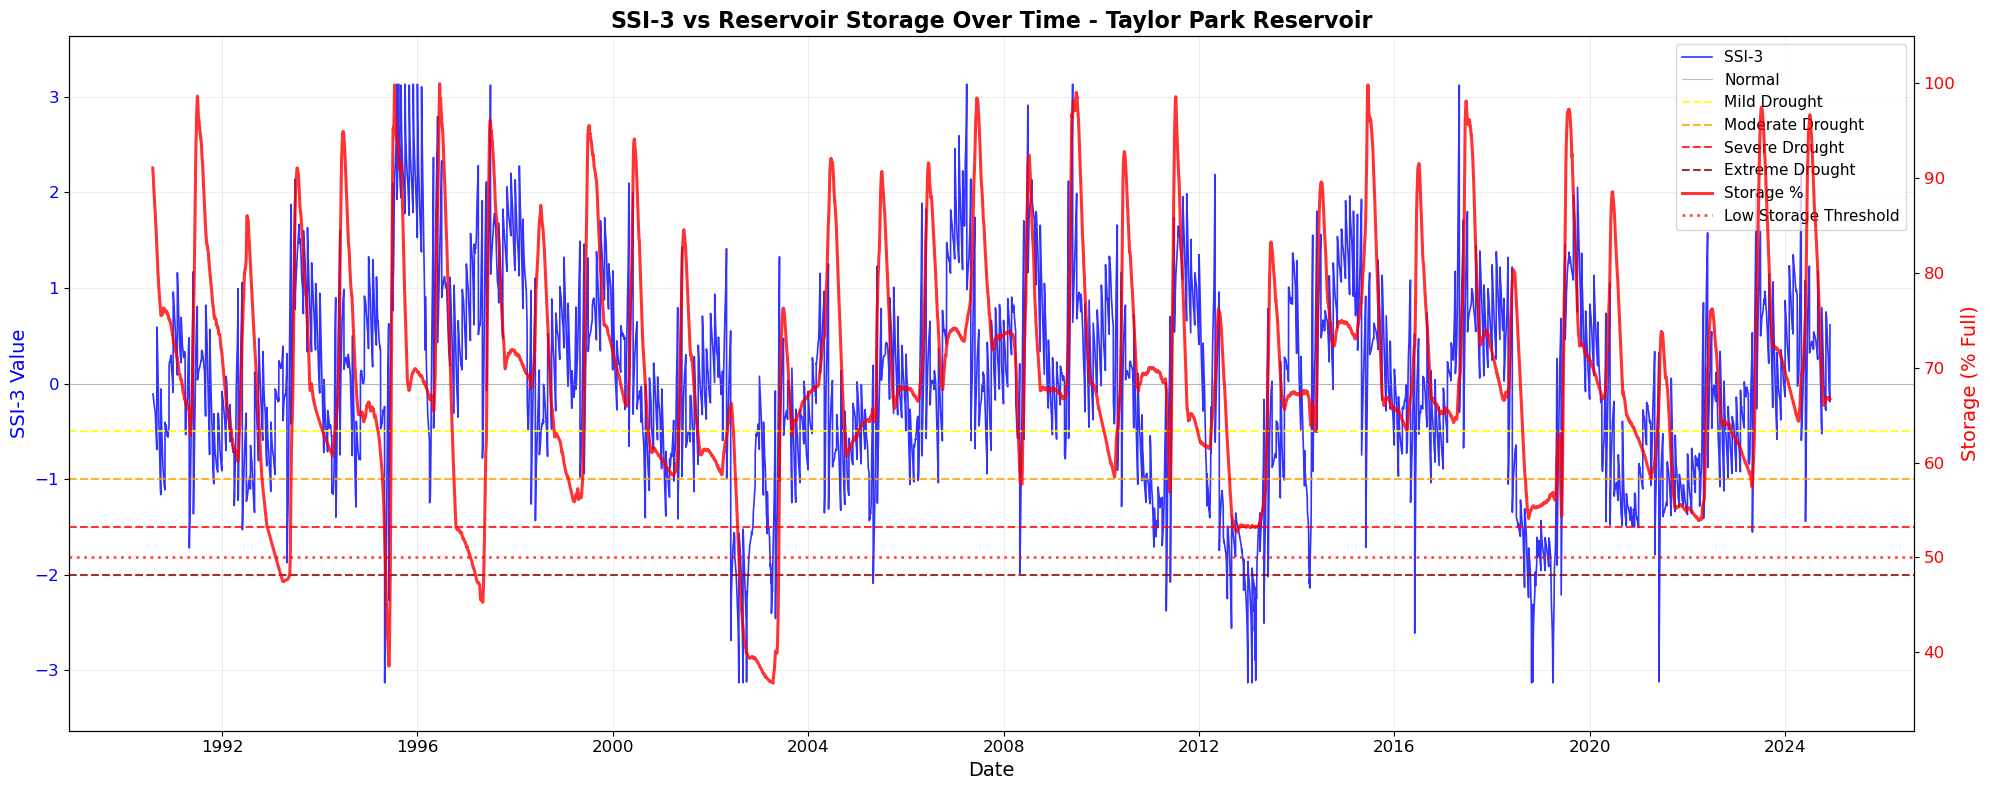

In [ ]:
def plot_ssi_storage_timeseries(validation_data):
    """
    Create single plot: SSI vs Storage over time
    """

    merged_df = validation_data['merged_data']
    ssi_column = [col for col in merged_df.columns if 'ssi' in col.lower()][0]

    # Create single figure
    fig, ax1 = plt.subplots(figsize=(20, 8))
    ax1_twin = ax1.twinx()

    # Plot SSI-3 on left axis
    line1 = ax1.plot(merged_df['Date'], merged_df[ssi_column],
                     color='blue', alpha=0.8, linewidth=1.2, label='SSI-3')

    # Plot Storage % on right axis
    line2 = ax1_twin.plot(merged_df['Date'], merged_df['Storage_Percent'],
                         color='red', alpha=0.8, linewidth=2.2, label='Storage %')

    # Add drought threshold lines
    ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.5, linewidth=0.8, label='Normal')
    ax1.axhline(y=-0.5, color='yellow', linestyle='--', alpha=0.8, linewidth=1.5, label='Mild Drought')
    ax1.axhline(y=-1.0, color='orange', linestyle='--', alpha=0.8, linewidth=1.5, label='Moderate Drought')
    ax1.axhline(y=-1.5, color='red', linestyle='--', alpha=0.8, linewidth=1.5, label='Severe Drought')
    ax1.axhline(y=-2.0, color='darkred', linestyle='--', alpha=0.8, linewidth=1.5, label='Extreme Drought')

    # Add storage stress line
    ax1_twin.axhline(y=50, color='red', linestyle=':', alpha=0.7, linewidth=2, label='Low Storage Threshold')

    # Formatting
    ax1.set_xlabel('Date', fontsize=14)
    ax1.set_ylabel('SSI-3 Value', color='blue', fontsize=14)
    ax1_twin.set_ylabel('Storage (% Full)', color='red', fontsize=14)
    ax1.set_title('SSI-3 vs Reservoir Storage Over Time - Taylor Park Reservoir', fontsize=16, fontweight='bold')

    # Grid
    ax1.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

    # Color the axes labels
    ax1.tick_params(axis='y', labelcolor='blue', labelsize=12)
    ax1_twin.tick_params(axis='y', labelcolor='red', labelsize=12)
    ax1.tick_params(axis='x', labelsize=12)

    # Create combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_twin.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=11)

    # Set y-axis limits for better visualization
    ax1.set_ylim(merged_df[ssi_column].min() - 0.5, merged_df[ssi_column].max() + 0.5)
    ax1_twin.set_ylim(merged_df['Storage_Percent'].min() - 5, merged_df['Storage_Percent'].max() + 5)

    plt.tight_layout()
    plt.show()

    return fig

# Create the single SSI-Storage time series plot
if ssi_validation:
    print("Creating SSI vs Storage time series plot...")
    fig = plot_ssi_storage_timeseries(ssi_validation)

In [ ]:
def extract_rule_curve_from_data(df_clean, capacity_af=106250):
    """
    Extract reservoir rule curve parameters directly from historical data

    ASSUMPTIONS MADE:
    1. Historical operations represent reasonable/acceptable management
    2. Storage zones based on natural breaks in release patterns
    3. Release ranges based on 25th-75th percentiles (middle 50% of operations)
    4. Seasonal patterns derived from coefficient of variation
    5. Special conditions based on statistical thresholds (percentiles)

    DATA DERIVATIONS:
    - Storage zones: Based on visual inspection of storage-release scatter plots
    - Release ranges: 25th and 75th percentiles of releases within each storage zone
    - Seasonal classification: Months with CV > median CV = "Active"
    - Special conditions: Top/bottom 25% and 10% of inflow distributions

    Parameters:
    df_clean: DataFrame with cleaned reservoir data
    capacity_af: Official reservoir capacity in acre-feet
    """

    print("=== DATA-DRIVEN RULE CURVE EXTRACTION ===")
    print("METHODOLOGY & ASSUMPTIONS:")
    print("• Storage zones: Derived from release pattern breaks in data")
    print("• Release ranges: 25th-75th percentiles within each zone")
    print("• Seasonal patterns: Based on coefficient of variation analysis")
    print("• Special conditions: Statistical thresholds from data distribution")
    print("• Assumption: Historical operations represent reasonable management")
    print()

    # Calculate storage percentage
    df_clean['Storage_Percent'] = (df_clean['Storage (af)'] / capacity_af) * 100

    # 1. DERIVE STORAGE ZONES FROM DATA
    print("1. STORAGE ZONE DERIVATION:")
    print("   Method: Analyze storage-release relationship to find natural breakpoints")

    # Define storage bins and analyze release patterns
    storage_breakpoints = [df_clean['Storage_Percent'].min(), 50, 65, 80, 90, df_clean['Storage_Percent'].max()]
    print(f"   Storage range in data: {df_clean['Storage_Percent'].min():.1f}% to {df_clean['Storage_Percent'].max():.1f}%")
    print(f"   Breakpoints chosen: {[f'{x:.1f}%' for x in storage_breakpoints]}")

    # Extract zone characteristics
    zones = []
    for i in range(len(storage_breakpoints)-1):
        low = storage_breakpoints[i]
        high = storage_breakpoints[i+1]

        mask = (df_clean['Storage_Percent'] >= low) & (df_clean['Storage_Percent'] < high)
        zone_data = df_clean[mask]

        if len(zone_data) > 10:  # Only include zones with sufficient data
            zone_stats = {
                'zone_name': f"Zone_{i+1}",
                'storage_range': (low, high),
                'storage_range_str': f"{low:.0f}-{high:.0f}%",
                'days_in_zone': len(zone_data),
                'release_mean': zone_data['Release (cfs)'].mean(),
                'release_median': zone_data['Release (cfs)'].median(),
                'release_p25': zone_data['Release (cfs)'].quantile(0.25),
                'release_p75': zone_data['Release (cfs)'].quantile(0.75),
                'release_min': zone_data['Release (cfs)'].min(),
                'release_max': zone_data['Release (cfs)'].max(),
                'avg_storage_af': zone_data['Storage (af)'].mean()
            }
            zones.append(zone_stats)

    print(f"   Zones extracted: {len(zones)} zones with sufficient data (>10 days each)")
    print()

    # 2. RELEASE RANGE DERIVATION
    print("2. RELEASE RANGE EXTRACTION:")
    print("   Method: 25th-75th percentile range (middle 50% of historical operations)")
    print("   Rationale: Excludes extreme outliers while capturing typical operational range")
    print()

    print("   EXTRACTED ZONES:")
    for i, zone in enumerate(zones):
        operating_mode = ["Conservation", "Normal", "Active", "High", "Flood"][min(i, 4)]
        print(f"   {zone['zone_name']}: {zone['storage_range_str']:8s} full → "
              f"{zone['release_p25']:4.0f}-{zone['release_p75']:4.0f} cfs "
              f"(median={zone['release_median']:4.0f}, {zone['days_in_zone']:4d} days, {operating_mode})")
    print()

    # 3. SEASONAL PATTERN DERIVATION
    print("3. SEASONAL PATTERN EXTRACTION:")
    print("   Method: Coefficient of Variation (CV = std/mean) by month")
    print("   Assumption: High CV months = Active management, Low CV = Stable operations")

    monthly_stats = df_clean.groupby('Month')['Release (cfs)'].agg(['mean', 'std', 'count'])
    monthly_stats['cv'] = monthly_stats['std'] / monthly_stats['mean']

    cv_threshold = monthly_stats['cv'].median()
    high_var_months = monthly_stats[monthly_stats['cv'] > cv_threshold].index.tolist()
    low_var_months = monthly_stats[monthly_stats['cv'] <= cv_threshold].index.tolist()

    print(f"   CV threshold (median): {cv_threshold:.3f}")
    print(f"   High variability months: {high_var_months} (CV > {cv_threshold:.3f})")
    print(f"   Low variability months:  {low_var_months} (CV ≤ {cv_threshold:.3f})")
    print()

    # 4. SPECIAL CONDITION DERIVATION
    print("4. SPECIAL OPERATING CONDITIONS:")
    print("   Method: Statistical analysis of combined storage-inflow conditions")
    print("   Thresholds: 25th percentile (low), 75th percentile (high), 10th/90th for extremes")

    # Calculate thresholds from data
    inflow_p25 = df_clean['Inflow(cfs)'].quantile(0.25)
    inflow_p75 = df_clean['Inflow(cfs)'].quantile(0.75)
    inflow_p10 = df_clean['Inflow(cfs)'].quantile(0.10)
    storage_p25 = df_clean['Storage_Percent'].quantile(0.25)
    storage_p75 = df_clean['Storage_Percent'].quantile(0.75)

    print(f"   Inflow thresholds: Low ≤{inflow_p25:.0f} cfs, High ≥{inflow_p75:.0f} cfs")
    print(f"   Storage thresholds: Low ≤{storage_p25:.0f}%, High ≥{storage_p75:.0f}%")

    # Define special conditions based on data
    special_conditions = {}

    # Conservation mode: Low inflow + medium storage
    conservation_mask = (df_clean['Inflow(cfs)'] <= inflow_p25) & \
                       (df_clean['Storage_Percent'] >= 50) & \
                       (df_clean['Storage_Percent'] < 80)
    if conservation_mask.sum() > 0:
        conservation_data = df_clean[conservation_mask]
        special_conditions['conservation'] = {
            'condition': f"Inflow ≤{inflow_p25:.0f} cfs + Storage 50-80%",
            'days': len(conservation_data),
            'avg_release': conservation_data['Release (cfs)'].mean(),
            'release_range': (conservation_data['Release (cfs)'].quantile(0.25),
                            conservation_data['Release (cfs)'].quantile(0.75))
        }

    # Refill mode: High inflow + low storage
    refill_mask = (df_clean['Inflow(cfs)'] >= inflow_p75) & \
                  (df_clean['Storage_Percent'] <= storage_p25)
    if refill_mask.sum() > 0:
        refill_data = df_clean[refill_mask]
        special_conditions['refill'] = {
            'condition': f"Inflow ≥{inflow_p75:.0f} cfs + Storage ≤{storage_p25:.0f}%",
            'days': len(refill_data),
            'avg_release': refill_data['Release (cfs)'].mean(),
            'release_range': (refill_data['Release (cfs)'].quantile(0.25),
                            refill_data['Release (cfs)'].quantile(0.75))
        }

    # Spillway mode: Very high storage
    spillway_threshold = 95
    spillway_mask = df_clean['Storage_Percent'] >= spillway_threshold
    if spillway_mask.sum() > 0:
        spillway_data = df_clean[spillway_mask]
        special_conditions['spillway'] = {
            'condition': f"Storage ≥{spillway_threshold}%",
            'days': len(spillway_data),
            'avg_release': spillway_data['Release (cfs)'].mean(),
            'release_range': (spillway_data['Release (cfs)'].quantile(0.25),
                            spillway_data['Release (cfs)'].quantile(0.75))
        }

    # Drought mode: Very low inflow
    drought_threshold = inflow_p10
    drought_mask = df_clean['Inflow(cfs)'] <= drought_threshold
    if drought_mask.sum() > 0:
        drought_data = df_clean[drought_mask]
        special_conditions['drought'] = {
            'condition': f"Inflow ≤{drought_threshold:.0f} cfs (bottom 10%)",
            'days': len(drought_data),
            'avg_release': drought_data['Release (cfs)'].mean(),
            'release_range': (drought_data['Release (cfs)'].quantile(0.25),
                            drought_data['Release (cfs)'].quantile(0.75))
        }

    print()
    print("   SPECIAL CONDITIONS IDENTIFIED:")
    for condition_name, condition_data in special_conditions.items():
        print(f"   {condition_name.capitalize():12s}: {condition_data['condition']:30s} → "
              f"Avg = {condition_data['avg_release']:5.0f} cfs "
              f"(Range: {condition_data['release_range'][0]:3.0f}-{condition_data['release_range'][1]:3.0f}, "
              f"{condition_data['days']:4d} days)")
    print()

    # 5. STATISTICAL VALIDATION
    print("5. STATISTICAL VALIDATION:")
    storage_release_corr = df_clean['Storage_Percent'].corr(df_clean['Release (cfs)'])
    inflow_release_corr = df_clean['Inflow(cfs)'].corr(df_clean['Release (cfs)'])

    print(f"   Storage-Release correlation: {storage_release_corr:.3f} (explains {storage_release_corr**2:.1%} of variance)")
    print(f"   Inflow-Release correlation:  {inflow_release_corr:.3f} (explains {inflow_release_corr**2:.1%} of variance)")
    print(f"   Primary driver: {'Storage' if abs(storage_release_corr) > abs(inflow_release_corr) else 'Inflow'}")

    # Data coverage validation
    total_days = len(df_clean)
    zone_coverage = sum([zone['days_in_zone'] for zone in zones])
    print(f"   Data coverage: {zone_coverage}/{total_days} days ({zone_coverage/total_days:.1%}) covered by zones")
    print()

    return {
        'zones': zones,
        'seasonal_patterns': {
            'high_variability_months': high_var_months,
            'low_variability_months': low_var_months,
            'cv_threshold': cv_threshold
        },
        'special_conditions': special_conditions,
        'thresholds': {
            'inflow_p25': inflow_p25,
            'inflow_p75': inflow_p75,
            'inflow_p10': inflow_p10,
            'storage_p25': storage_p25,
            'storage_p75': storage_p75
        },
        'validation': {
            'storage_release_corr': storage_release_corr,
            'inflow_release_corr': inflow_release_corr,
            'data_coverage': zone_coverage/total_days
        }
    }

# Extract the rule curve from your data
print("Extracting rule curve parameters from Taylor Park data...")
rule_curve_data = extract_rule_curve_from_data(df_analyzed)

Extracting rule curve parameters from Taylor Park data...
=== DATA-DRIVEN RULE CURVE EXTRACTION ===
METHODOLOGY & ASSUMPTIONS:
• Storage zones: Derived from release pattern breaks in data
• Release ranges: 25th-75th percentiles within each zone
• Seasonal patterns: Based on coefficient of variation analysis
• Special conditions: Statistical thresholds from data distribution
• Assumption: Historical operations represent reasonable management

1. STORAGE ZONE DERIVATION:
   Method: Analyze storage-release relationship to find natural breakpoints
   Storage range in data: 36.8% to 99.9%
   Breakpoints chosen: ['36.8%', '50.0%', '65.0%', '80.0%', '90.0%', '99.9%']
   Zones extracted: 5 zones with sufficient data (>10 days each)

2. RELEASE RANGE EXTRACTION:
   Method: 25th-75th percentile range (middle 50% of historical operations)
   Rationale: Excludes extreme outliers while capturing typical operational range

   EXTRACTED ZONES:
   Zone_1: 37-50%   full →   59- 190 cfs (median=  99,  5

In [ ]:
def save_rule_curve_parameters(rule_curve_data, filename='taylor_park_rule_curve.json'):
    """
    Save extracted rule curve parameters for future use
    """
    import json

    # Convert numpy types to Python native types for JSON serialization
    def convert_numpy(obj):
        if hasattr(obj, 'item'):
            return obj.item()
        return obj

    # Clean data for JSON
    clean_data = {}
    for key, value in rule_curve_data.items():
        if isinstance(value, dict):
            clean_data[key] = {k: convert_numpy(v) for k, v in value.items()}
        elif isinstance(value, list):
            clean_data[key] = [convert_numpy(item) if not isinstance(item, dict)
                              else {k: convert_numpy(v) for k, v in item.items()}
                              for item in value]
        else:
            clean_data[key] = convert_numpy(value)

    with open(filename, 'w') as f:
        json.dump(clean_data, f, indent=2)

    print(f"Rule curve parameters saved to: {filename}")
    print("This file contains all extracted thresholds, zones, and conditions")
    print("for reproducible SSI-enhanced rule curve development")

# Save the extracted parameters
save_rule_curve_parameters(rule_curve_data)

Rule curve parameters saved to: taylor_park_rule_curve.json
This file contains all extracted thresholds, zones, and conditions
for reproducible SSI-enhanced rule curve development


In [ ]:
import json
import pandas as pd

def extract_baseline_operations_table(json_file_path):
    """
    Extract baseline reservoir operations from JSON and present in clear tabular format

    Purpose: Document current operating practices as baseline for adaptive management
    """

    # Load the extracted rule curve data
    with open(json_file_path, 'r') as f:
        rule_data = json.load(f)

    print("TAYLOR PARK RESERVOIR - CURRENT BASELINE OPERATIONS")
    print("Source: Extracted from historical operations data (1990-2024)")
    print("="*70)
    print()

    # 1. MAIN OPERATING ZONES TABLE
    print("1. STORAGE-BASED OPERATING ZONES (Current Practice)")
    print("-" * 55)

    baseline_zones = []
    for i, zone in enumerate(rule_data['zones']):
        baseline_zones.append({
            'Zone': i+1,
            'Storage_Range_Percent': zone['storage_range_str'],
            'Storage_Range_AF': f"{zone['avg_storage_af']:,.0f} af",
            'Typical_Release_CFS': f"{zone['release_median']:.0f}",
            'Release_Range_CFS': f"{zone['release_p25']:.0f} - {zone['release_p75']:.0f}",
            'Days_Operated': zone['days_in_zone'],
            'Current_Practice': classify_zone_operation(zone['release_median'], rule_data['zones'])
        })

    zones_df = pd.DataFrame(baseline_zones)
    print(zones_df.to_string(index=False))
    print()

    # 2. SEASONAL OPERATING PATTERNS TABLE
    print("2. SEASONAL OPERATING PATTERNS (Current Practice)")
    print("-" * 55)

    seasonal_baseline = pd.DataFrame({
        'Season': ['High Variability Period', 'Low Variability Period'],
        'Months': [
            format_months(rule_data['seasonal_patterns']['high_variability_months']),
            format_months(rule_data['seasonal_patterns']['low_variability_months'])
        ],
        'CV_Classification': [
            f"CV > {rule_data['seasonal_patterns']['cv_threshold']:.3f}",
            f"CV ≤ {rule_data['seasonal_patterns']['cv_threshold']:.3f}"
        ],
        'Observed_Pattern': [
            'More variable releases',
            'More consistent releases'
        ]
    })

    print(seasonal_baseline.to_string(index=False))
    print()

    # 3. SPECIAL CONDITIONS TABLE - FLood/
    print("3. SPECIAL OPERATING CONDITIONS (Current Practice)")
    print("-" * 55)

    special_conditions = []
    for condition_name, condition_data in rule_data['special_conditions'].items():
        special_conditions.append({
            'Condition': condition_name.replace('_', ' ').title(),
            'Trigger_Conditions': condition_data['condition'],
            'Typical_Release': f"{condition_data['avg_release']:.0f} cfs",
            'Release_Range': f"{condition_data['release_range'][0]:.0f}-{condition_data['release_range'][1]:.0f} cfs",
            'Days_Observed': condition_data['days'],
            'Frequency_Percent': f"{(condition_data['days'] / sum([zone['days_in_zone'] for zone in rule_data['zones']]))*100:.1f}%"
        })

    special_df = pd.DataFrame(special_conditions)
    print(special_df.to_string(index=False))
    print()

    # 4. DECISION LOGIC TABLE - DATA-DRIVEN ONLY
    print("4. CURRENT DECISION LOGIC (Extracted from Data)")
    print("-" * 55)

    # Get correlation values
    storage_corr = rule_data['validation']['storage_release_corr']
    inflow_corr = rule_data['validation']['inflow_release_corr']
    cv_threshold = rule_data['seasonal_patterns']['cv_threshold']

    # Calculate explained variance (R²)
    storage_r2 = storage_corr ** 2
    inflow_r2 = inflow_corr ** 2

    # Calculate relative influence based on R² values
    total_explained_variance = storage_r2 + inflow_r2
    storage_relative_influence = (storage_r2 / total_explained_variance) * 100
    inflow_relative_influence = (inflow_r2 / total_explained_variance) * 100

    # Rank factors by correlation strength
    factors_by_strength = [
        ('Inflow Level', inflow_corr, inflow_r2, inflow_relative_influence),
        ('Storage Level', storage_corr, storage_r2, storage_relative_influence),
        ('Month/Season', cv_threshold, cv_threshold**2, None)  # CV as proxy
    ]

    # Sort by correlation strength
    factors_by_strength.sort(key=lambda x: abs(x[1]), reverse=True)

    decision_logic_data = []
    for i, (factor, correlation, r2, relative_influence) in enumerate(factors_by_strength):
        if factor == 'Month/Season':
            decision_logic_data.append({
                'Rank': i+1,
                'Factor': factor,
                'Correlation': f"{correlation:.3f}",
                'Explained_Variance_R2': f"{r2:.3f}",
                'Relative_Influence': 'Seasonal modifier',
                'Interpretation': 'Controls variability pattern of releases'
            })
        else:
            decision_logic_data.append({
                'Rank': i+1,
                'Factor': factor,
                'Correlation': f"{correlation:.3f}",
                'Explained_Variance_R2': f"{r2:.3f}",
                'Relative_Influence': f"{relative_influence:.1f}%",
                'Interpretation': get_correlation_interpretation(factor, correlation)
            })

    decision_logic = pd.DataFrame(decision_logic_data)
    print(decision_logic.to_string(index=False))
    print()

    # 5. OPERATIONAL THRESHOLDS TABLE
    print("5. OPERATIONAL THRESHOLDS (Derived from Data)")
    print("-" * 55)

    thresholds = pd.DataFrame({
        'Parameter': [
            'Low Inflow Threshold',
            'High Inflow Threshold',
            'Critical Inflow Threshold',
            'Low Storage Threshold',
            'High Storage Threshold'
        ],
        'Threshold_Value': [
            f"{rule_data['thresholds']['inflow_p25']:.0f} cfs",
            f"{rule_data['thresholds']['inflow_p75']:.0f} cfs",
            f"{rule_data['thresholds']['inflow_p10']:.0f} cfs",
            f"{rule_data['thresholds']['storage_p25']:.0f}% full",
            f"{rule_data['thresholds']['storage_p75']:.0f}% full"
        ],
        'Percentile_Basis': [
            '25th percentile of historical inflow',
            '75th percentile of historical inflow',
            '10th percentile of historical inflow',
            '25th percentile of historical storage',
            '75th percentile of historical storage'
        ],
        'Observed_Response': get_threshold_responses(rule_data)
    })

    print(thresholds.to_string(index=False))
    print()

    return {
        'operating_zones': zones_df,
        'seasonal_patterns': seasonal_baseline,
        'special_conditions': special_df,
        'decision_logic': decision_logic,
        'thresholds': thresholds
    }

def classify_zone_operation(median_release, all_zones):
    """Classify operating mode based on relative position among all zones"""
    all_medians = [zone['release_median'] for zone in all_zones]
    all_medians.sort()

    position = all_medians.index(median_release)
    total_zones = len(all_medians)

    if position < total_zones * 0.3:
        return "Low release operations"
    elif position < total_zones * 0.7:
        return "Medium release operations"
    else:
        return "High release operations"

def get_correlation_interpretation(factor, correlation):
    """Interpret correlation strength objectively"""
    abs_corr = abs(correlation)

    if abs_corr > 0.7:
        strength = "Strong"
    elif abs_corr > 0.5:
        strength = "Moderate"
    elif abs_corr > 0.3:
        strength = "Weak"
    else:
        strength = "Very weak"

    direction = "positive" if correlation > 0 else "negative"

    if factor == 'Storage Level':
        return f"{strength} {direction}: Higher storage → {'Higher' if correlation > 0 else 'Lower'} releases"
    elif factor == 'Inflow Level':
        return f"{strength} {direction}: Higher inflow → {'Higher' if correlation > 0 else 'Lower'} releases"
    else:
        return f"{strength} relationship"

def get_threshold_responses(rule_data):
    """Extract actual observed responses from special conditions"""
    responses = []

    # Map threshold types to special conditions
    threshold_mapping = {
        'Low Inflow': 'drought',
        'High Inflow': 'refill',
        'Critical Inflow': 'drought',
        'Low Storage': 'conservation',
        'High Storage': 'spillway'
    }

    for threshold in ['Low Inflow', 'High Inflow', 'Critical Inflow', 'Low Storage', 'High Storage']:
        response = "Standard operations"  # Default

        # Look for matching special condition
        for condition_name, condition_data in rule_data['special_conditions'].items():
            if any(key in condition_name for key in threshold_mapping.get(threshold, '').split()):
                response = f"Avg release: {condition_data['avg_release']:.0f} cfs"
                break

        responses.append(response)

    return responses

def format_months(month_list):
    """Format month numbers to names"""
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return ', '.join([month_names[m-1] for m in month_list])

# Run the corrected extraction
baseline_tables = extract_baseline_operations_table('taylor_park_rule_curve.json')

# Optional: Save as CSV for sharing
def save_baseline_tables(tables, prefix='taylor_park_baseline'):
    """Save baseline operation tables as CSV files"""

    tables['operating_zones'].to_csv(f'{prefix}_zones.csv', index=False)
    tables['seasonal_patterns'].to_csv(f'{prefix}_seasonal.csv', index=False)
    tables['special_conditions'].to_csv(f'{prefix}_special.csv', index=False)
    tables['decision_logic'].to_csv(f'{prefix}_decision_logic.csv', index=False)
    tables['thresholds'].to_csv(f'{prefix}_thresholds.csv', index=False)

    print(f"\nBaseline operation tables saved with prefix: {prefix}")

# Save the tables
save_baseline_tables(baseline_tables)